In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import * 
from IPython.display import Image, display_svg, SVG
 
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8



In [ ]:
path = Path('../../..')
Path.BASE_PATH = path


In [ ]:
to = load_pickle(path/'models/splits.pkl')

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
valid_xs.shape, valid_y.shape

## Function for metric (RMSE)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y): return r_mse(m.predict(xs),y)

## Train model without cleaning data

In [ ]:
def rf(xs, y, n_estimators=60,
        max_features = 0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [ ]:
m = rf(xs,y)

## Results

In [ ]:
print(f'root mean square error for - training set: {m_rmse(m,xs,y)}, and validation set: {m_rmse(m,valid_xs,valid_y)}')

In [ ]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

## Find feature importance

In [ ]:
def rf_feat_importance(m,df_2016_T07):
    return pd.DataFrame({'cols':df_2016_T07.columns, 'imp':m.feature_importances_}
                        ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m,xs)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

## Remove unimportant features

In [14]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

12

In [15]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [16]:
m = rf(xs_imp, y)

## Results

In [17]:
print(f'root mean square error for - test set: {m_rmse(m,xs_imp,y)}, and validation set: {m_rmse(m,valid_xs_imp,valid_y)}')

root mean square error for - test set: 1.460191, and validation set: 1.433904


In [18]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

out-of-bag error: 1.77648


## Remove redundant features

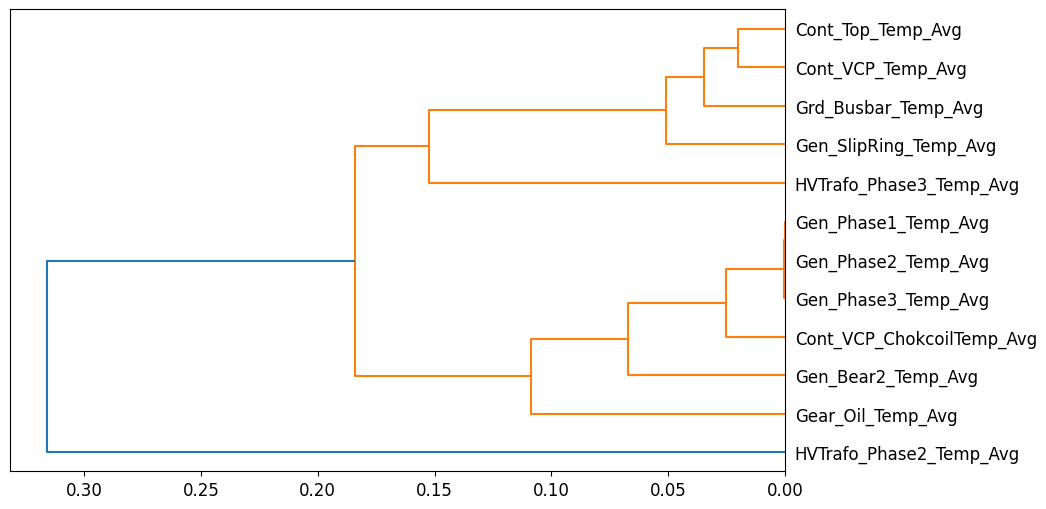

In [21]:
cluster_columns(xs_imp)

In [19]:
def get_oob(df_2016_T07):
    m = RandomForestRegressor(n_estimators=60, min_samples_leaf=15,
        max_features=0.5, n_jobs=1, oob_score=True)
    m.fit(df_2016_T07,y)
    return m.oob_score_

In [22]:
{c:get_oob(xs_imp.drop(c,axis=1)) for c in (
    'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Cont_Top_Temp_Avg','Cont_VCP_Temp_Avg'
)}

{'Gen_Phase1_Temp_Avg': 0.9828956602868586,
 'Gen_Phase2_Temp_Avg': 0.9828950053493115,
 'Gen_Phase3_Temp_Avg': 0.9827241182933499,
 'Cont_Top_Temp_Avg': 0.9822984543490936,
 'Cont_VCP_Temp_Avg': 0.982615704947065}

In [23]:
to_drop = ['Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Cont_VCP_Temp_Avg']
get_oob(xs_imp.drop(to_drop,axis=1))

0.9824758211288199

In [24]:
xs_final = xs_imp.drop(to_drop,axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [25]:


m = rf(xs_final,y)


In [26]:
save_pickle(path/'models/final_model.pkl', m)

In [29]:
save_pickle(path/'models/final_data_train.pkl',xs_final)
save_pickle(path/'models/final_data_val.pkl',valid_xs_final)

## Final Results

In [27]:
print(f'root mean square error for - test set: {m_rmse(m,xs_final,y)}, and validation set: {m_rmse(m,valid_xs_final,valid_y)}')

root mean square error for - test set: 1.474572, and validation set: 1.477935


In [28]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

out-of-bag error: 1.778286
